In [1]:
from cfdmod.use_cases.s1.probe import S1Probe
import lnas
from lnas.transformations import TransformationsMatrix
import pandas as pd
import numpy as np
import pathlib
from cfdmod.use_cases.s1.profile import Profile
from cfdmod.api.vtk.probe_vtm import read_vtm, create_line, probe_over_line, get_array_from_filter
import matplotlib.pyplot as plt
from cfdmod.use_cases.s1.plotting import set_style_tech
from nassu.cfg.model import ConfigScheme

# Calculating topographic factors from vtm

# Variables

In [ ]:
case = '350'
scale = 16
version = 'v0'
timestep = 18500
save_plots = True
save_csvs = True
use_analytic_pitot = False

project_path = pathlib.Path(f"/mnt/disk01/prd-eng/cases/s1_consulting_nassu_test/025_BrookfieldAlceu/")
field_data_path = project_path / f"{version}/{case}/000/macrs/stats/default/macrs_{str(timestep).zfill(7)}.vtm"

df_probes_list = pd.read_csv(project_path / "simulation_data/configs_cfdmod/034_probes.csv")
# df_pitots_list = pd.read_csv(project_path / "configs/cfdmod/pitots.csv")
# df_pitot_analytic = pd.read_csv("/mnt/dev01_fs_shared/aron/repos/nassuArtifacts/SEM/profile_log_cat2_offset1.4_H15_Uh0.04.csv")

cfg = ConfigScheme.from_file(pathlib.Path(project_path / f"simulation_data/configs_cfdmod/roughness_params_s24.yaml"))

# Functions definition

In [168]:
def find_case_in_config(case: str, cfg: ConfigScheme) -> dict:
    for current_case in cfg.simulations:
        if case == current_case['name']:
            case_cfg = current_case
    return case_cfg

In [169]:
def apply_sequence_of_transformations(df: pd.DataFrame, list_of_transformations: list):
    points = df[['x','y','z']].to_numpy()
    for transformation in list_of_transformations:
        #initialize with dummy values:
        T_dict = {}
        T_dict['rotation'] = np.array((0, 0, 0))
        T_dict['translation'] = np.array((0, 0, 0))
        T_dict['scale'] = np.array((1, 1, 1))
        T_dict['fixed_point'] = np.array((0, 0, 0))
        #overwrite with actual transformations:
        for operation in transformation['transformation']:
            T_dict[operation] = np.array(transformation['transformation'][operation])
        T = TransformationsMatrix( angle = T_dict['rotation'], 
                                  translation = T_dict['translation'], 
                                  scale = T_dict['scale'],
                                  fixed_point= T_dict['fixed_point'],
        )
        points = T.apply_points(points)
    df[['x_l','y_l','z_l']] = points
    return df

In [170]:
def process_velocity_profile(df_names, vtm_field, scale, label):
    df_coordinate = df_names[['x_l','y_l','z_l']].to_numpy()[0]
    df_probe = S1Probe(p1=df_coordinate.tolist(), p2=(df_coordinate+np.array((0,0,100/16))).tolist(), numPoints=1000)
    df_line = create_line(df_probe.p1, df_probe.p2, df_probe.numPoints - 1)
    df_filter = probe_over_line(df_line, vtm_field)
    df_data = get_array_from_filter(df_filter, array_lbl="ux")
    df_heights = np.linspace(df_probe.p1[2], df_probe.p2[2], df_probe.numPoints)*scale
    df_profile = Profile(heights=df_heights, values=df_data, label=label)
    df_profile.smoothen_values()
    return df_profile

In [171]:
def plot_velocity_profiles(profiles, n_pts_to_ignore):
    fig, ax = plt.subplots(figsize=(10 / 2.54, 10 / 2.54), constrained_layout=True, dpi=120)
    for profile in profiles:
        ax.plot(profiles[profile].values[n_pts_to_ignore:], (profiles[profile].heights-profiles[profile].heights[0])[n_pts_to_ignore:], label=profiles[profile].label)
    ax.legend()
    ax.set_ylim(0, 100)
    set_style_tech(ax)
    plt.show(fig)
    return fig

In [172]:
def plot_S1_profiles(s1_profiles, n_pts_to_ignore):
    fig, ax = plt.subplots(figsize=(10 / 2.54, 10 / 2.54), constrained_layout=True, dpi=120)
    for profile in s1_profiles:
        ax.plot(s1_profiles[profile].values[n_pts_to_ignore:], s1_profiles[profile].heights[n_pts_to_ignore:], label=s1_profiles[profile].label)
    ax.legend(loc="upper left")
    ax.set_xlim(0.4, 1.6)
    ax.set_ylim(0, 100)
    set_style_tech(ax)
    plt.show(fig)
    return fig

In [173]:
def save_plot_file(file_path: pathlib.Path, fig: plt):
    file_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(str(file_path))

# Execution

In [174]:
# read main files
vtm_field = read_vtm(field_data_path)
case_cfg = find_case_in_config(case=case, cfg=cfg)

In [175]:
# transform points
list_of_transformations = case_cfg['domain']['global_transformations']
df_pitots_list = apply_sequence_of_transformations(df_pitots_list, list_of_transformations)
df_probes_list = apply_sequence_of_transformations(df_probes_list, list_of_transformations)

In [176]:
#process pitot velocity profile
if use_analytic_pitot == False:
    df_pitot_of_case = df_pitots_list[df_pitots_list['case']==int(case)]
    pitot_velocity_profile = process_velocity_profile(df_pitot_of_case, vtm_field, scale=scale, label="Pitot")
else:
    pitot_velocity_profile = Profile(heights=df_pitot_analytic['z']*scale, values=df_pitot_analytic['ux'], label="Pitot")

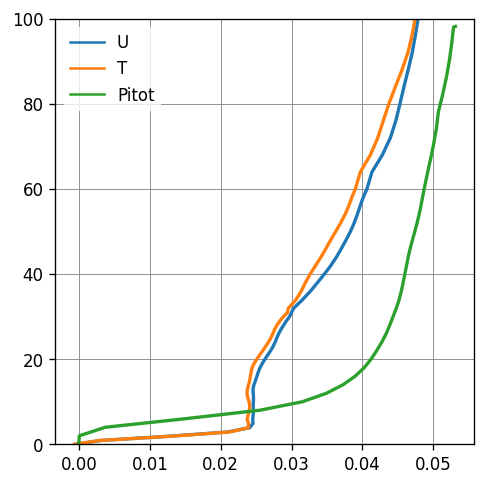

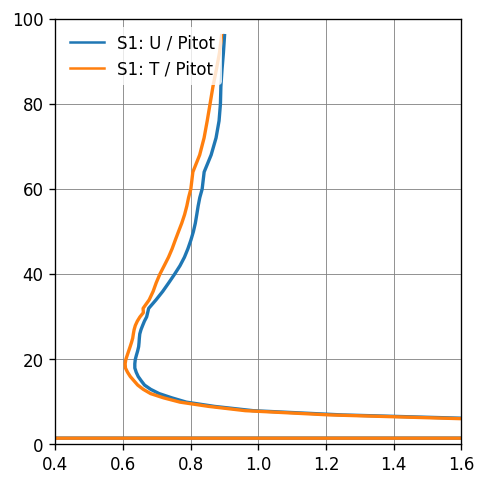

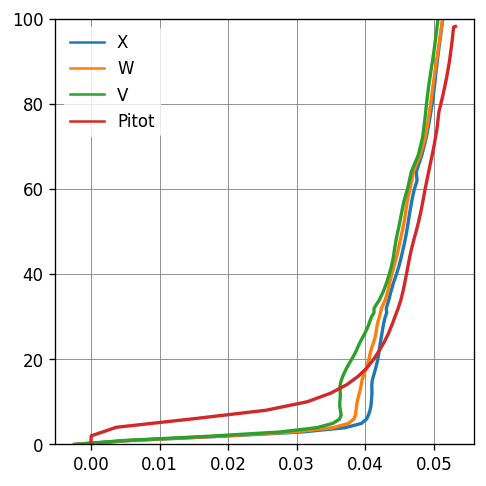

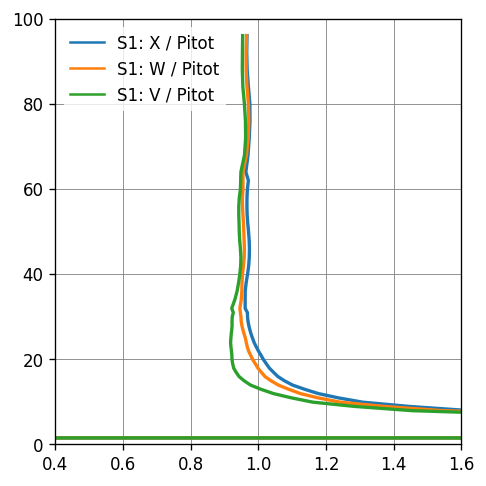

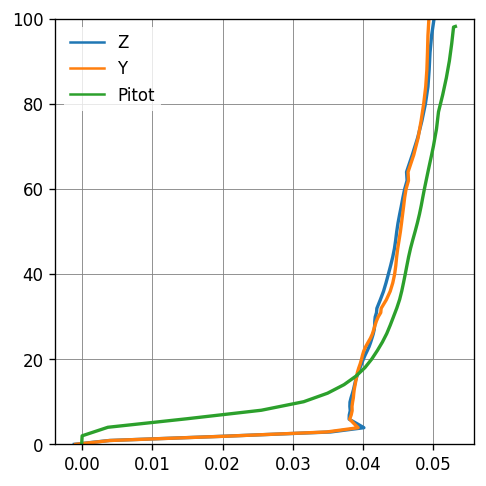

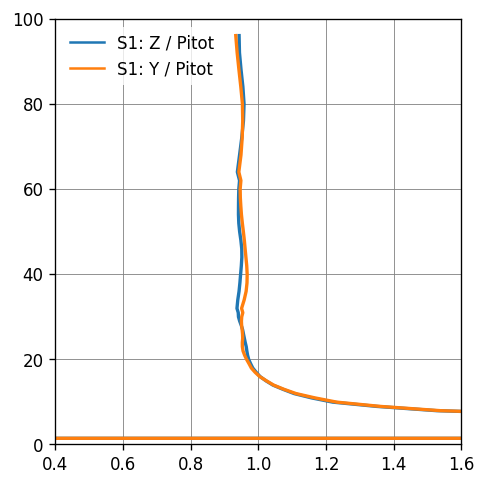

In [177]:
#process probes profiles
df_probes_of_case = df_probes_list[df_probes_list['case']==int(case)]
list_of_buildings = df_probes_of_case['building'].unique().tolist()
for building in list_of_buildings:
    #process all profiles from one case + building
    df_probes_of_case_and_building = df_probes_of_case[df_probes_of_case['building']==building]
    list_of_probe_names = df_probes_of_case_and_building['probe_name'].to_list()
    list_of_section_names = df_probes_of_case_and_building['section'].to_list()
    velocity_profiles = {}
    s1_profiles = {}
    for current_probe_name, current_section_name in zip(list_of_probe_names, list_of_section_names):
        #process profile of one probe
        df_current_probe = df_probes_of_case_and_building[df_probes_of_case_and_building['probe_name']==current_probe_name]
        velocity_profiles[current_probe_name] = process_velocity_profile(df_current_probe, vtm_field, scale=scale, label=current_section_name)
        s1_profiles[current_probe_name] = velocity_profiles[current_probe_name] / pitot_velocity_profile

    velocity_profiles['Pitot'] = pitot_velocity_profile
    
    #save csvs
    if save_csvs == True:
        for probe in velocity_profiles:
            df_velocities = pd.DataFrame()
            df_velocities[probe+"_z"] = velocity_profiles[probe].heights - velocity_profiles[probe].heights[0]
            df_velocities[probe+"_v"] = velocity_profiles[probe].values
            velocity_profiles_figure_path = project_path / ("post_processing/" + case + "/csvs/" + f"V_{probe}.csv")
            velocity_profiles_figure_path.parent.mkdir(parents=True, exist_ok=True)
            df_velocities.to_csv(str(velocity_profiles_figure_path))

    #2 plot for each case + building: velocity and s1 profiles
    n_pts_to_ignore = 0

    fig_velocity = plot_velocity_profiles(velocity_profiles, n_pts_to_ignore=n_pts_to_ignore)
    fig_s1 = plot_S1_profiles(s1_profiles, n_pts_to_ignore=n_pts_to_ignore)
    
    if save_plots == True:
        velocity_profiles_figure_path = project_path / ("post_processing/" + case + "/V/" + f"V_{building}.png")
        save_plot_file(velocity_profiles_figure_path, fig_velocity)
        S1_profiles_figure_path = project_path / ("post_processing/" + case + "/S1/" + f"S1_{building}.png")
        save_plot_file(S1_profiles_figure_path, fig_s1)

In [178]:
df_current_probe

,probe_name,case,section,building,x,y,z,x_l,y_l,z_l
65,GE-350-Y,350,Y,GE,-166.2,-70.1,820.8,178.418891,86.118459,11.9875
